# Imports

In [1]:
# use pip install cupy-cuda12x to import cupy
# you might need to install cuda toolkit from https://developer.nvidia.com/cuda-toolkit
import cupy as cp
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns
from tqdm import tqdm
import pickle

KeyboardInterrupt: 

# Loading saved reduced data

In [6]:
# loading the PCA-reduced data and labels from the .npz file
data = np.load('pca_reduced_data.npz')

train_pca = data['train_pca']
val_pca = data['val_pca']
test_pca = data['test_pca']

train_labels = data['train_labels']
val_labels = data['val_labels']
test_labels = data['test_labels']

print(f"Train PCA shape: {train_pca.shape}")
print(f"Validation PCA shape: {val_pca.shape}")
print(f"Test PCA shape: {test_pca.shape}")

Train PCA shape: (10924, 411)
Validation PCA shape: (2342, 411)
Test PCA shape: (2342, 411)


# SVM Class

In [3]:
class SVMClassifier:
    def __init__(self, C=1.0, gamma=0.1):
        # initialize the hyperparameters
        self.C = C
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = 0


    def rbf_kernel(self, X1, X2):
        # Compute the RBF kernel matrix
        if X2 is None:
            X2 = X1
        # Compute the squared norms of each row in X1 and X2
        X1_sq = cp.sum(X1 ** 2, axis=1).reshape(-1, 1)
        X2_sq = cp.sum(X2 ** 2, axis=1).reshape(1, -1)
        # Compute the squared Euclidean distances
        sq_dists = X1_sq + X2_sq - 2 * cp.dot(X1, X2.T)
        # Compute the RBF kernel
        K = cp.exp(-self.gamma * sq_dists)
        return K

    def fit(self, X, y):
        X = cp.asarray(X)
        y = cp.asarray(y)

        # Number of samples and features
        n_samples, n_features = X.shape

        # converting labels to {-1, 1}
        y = cp.where(y == 1, 1, -1)

        # Compute the kernel matrix
        K = self.rbf_kernel(X, X)

        # seting up parameters for cvxopt
        P = matrix(cp.asnumpy(cp.outer(y, y) * K), tc='d')
        q = matrix(-np.ones(n_samples), tc='d')

        # Equality constraints
        A = matrix(cp.asnumpy(y).astype(np.float64).reshape(1, -1), tc='d')
        b = matrix(0.0, tc='d')

        # Inequality constraints
        G_std = np.diag(-np.ones(n_samples))
        h_std = matrix(np.zeros(n_samples), tc='d')

        # Slack variables
        G_slack = np.diag(np.ones(n_samples))
        h_slack = matrix(np.ones(n_samples) * self.C, tc='d')

        # Stack matrices
        G = matrix(np.vstack((G_std, G_slack)), tc='d')
        h = matrix(np.vstack((h_std, h_slack)), tc='d')

        # solving QP problem using cvxopt
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        alphas = np.array(solution['x']).flatten()

        # support vectors have non zero lagrange multipliers
        sv = alphas > 1e-5
        ind = np.arange(len(alphas))[sv]
        self.alpha = alphas[sv]
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]

        # calculating bias
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.support_vector_labels[n]
            self.b -= cp.sum(self.alpha * self.support_vector_labels * K[ind[n], sv])
        self.b /= len(self.alpha)

    def project(self, X):
        X = cp.asarray(X)
        # computes the projection of the input samples
        K = self.rbf_kernel(X, self.support_vectors)
        return cp.dot(K, self.alpha * self.support_vector_labels) + self.b

    def predict(self, X):
        # Predict the class labels for the input samples
        return np.where(self.project(X) >= 0, 1, 0)

# Training the SVM model


In [7]:
# initializing the SVM classifier
# svm_classifier = SVMClassifier(C=1, gamma=0.0001)
svm_classifier = SVC(C=5, gamma=0.0001, kernel='rbf')

# Training the classifier
svm_classifier.fit(train_pca, train_labels)

SVC(C=5, gamma=0.0001)

# Evaluating the SVM model


SVM Train Accuracy: 0.9867
SVM Test Accuracy: 0.9146
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       878
           1       0.92      0.95      0.93      1464

    accuracy                           0.91      2342
   macro avg       0.91      0.90      0.91      2342
weighted avg       0.91      0.91      0.91      2342



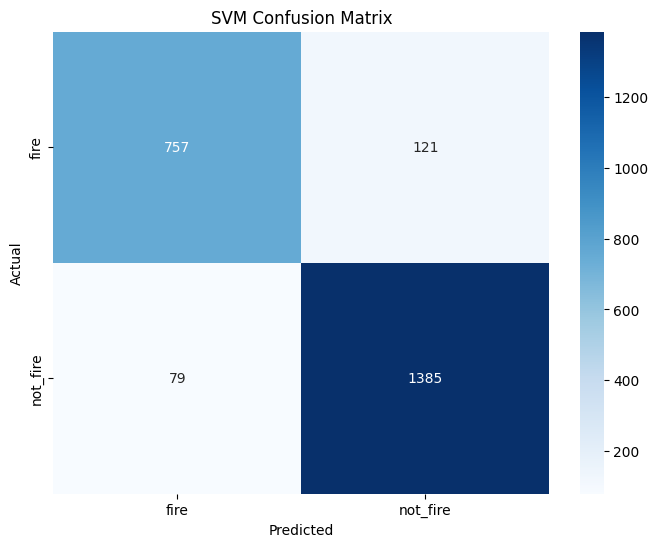

In [8]:
# predicting labels for the train set
train_predictions = svm_classifier.predict(train_pca)

# computing accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"SVM Train Accuracy: {accuracy:.4f}")

# predicting labels for the test set
test_predictions = svm_classifier.predict(test_pca)

# computing accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"SVM Test Accuracy: {accuracy:.4f}")

# classification report from sklearn
class_report = classification_report(test_labels, test_predictions)
print("SVM Classification Report:\n", class_report)

# confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# class names
class_names = ['fire', 'not_fire'] 

# plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()

# Save model

In [9]:
# path where the model is saved
model_path = 'svm_model_5_0001.pkl'

# saving the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(svm_classifier, file)

print(f"Model saved to {model_path}")

Model saved to svm_model_5_0001.pkl


# Load Model and Evaluate

Model loaded successfully.
SVM Test Accuracy: 0.9146
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       878
           1       0.92      0.95      0.93      1464

    accuracy                           0.91      2342
   macro avg       0.91      0.90      0.91      2342
weighted avg       0.91      0.91      0.91      2342



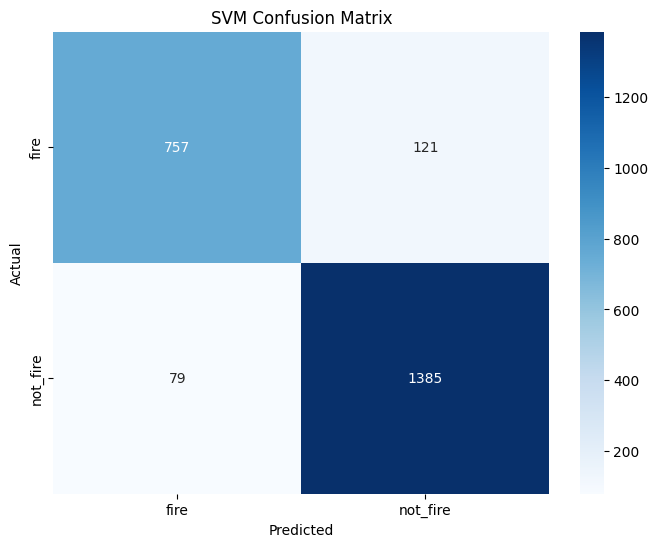

In [10]:
model_path = 'svm_model_5_0001.pkl'

# Load the model from the file
with open(model_path, 'rb') as file:
    loaded_svm_classifier = pickle.load(file)

print("Model loaded successfully.")

# predicting labels for the test set
test_predictions = loaded_svm_classifier.predict(test_pca)

# Ccomputing accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"SVM Test Accuracy: {accuracy:.4f}")

# classification report from sklearn
class_report = classification_report(test_labels, test_predictions)
print("SVM Classification Report:\n", class_report)

# confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# class names
class_names = ['fire', 'not_fire'] 

# plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()


# Grid Search

In [8]:
param_grid = [
    {'C': 5, 'gamma': 0.0005, 'kernel': 'rbf'},
    {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'},
    {'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'},
    {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'},
    {'C': 5, 'gamma': 0.00005, 'kernel': 'rbf'},
    
	{'C': 5, 'gamma': 0.000001, 'kernel': 'sigmoid'},
    {'C': 100, 'gamma': 0.000001, 'kernel': 'sigmoid'},
    {'C': 1000, 'gamma': 0.000001, 'kernel': 'sigmoid'},
    
	{'C': 10000, 'gamma': 0.000008, 'kernel': 'poly'},
	{'C': 10000, 'gamma': 0.00001, 'kernel': 'poly'},
    {'C': 5000, 'gamma': 0.00001, 'kernel': 'poly'},
    {'C': 10000, 'gamma': 0.000015, 'kernel': 'poly'},
]

# Store results
results = []

# Iterate over each parameter combination
for params in tqdm(param_grid):
    # Initialize the SVC model with the current parameters
    svc = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'])
    
    # Train the model
    svc.fit(train_pca, train_labels)
    
    # Evaluate on the test set
    test_predictions = svc.predict(test_pca)
    accuracy = accuracy_score(test_labels, test_predictions)
    class_report = classification_report(test_labels, test_predictions, zero_division=0)
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    
    # Store the results
    results.append({
        'params': params,
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix
    })

# Print the results
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:\n", result['classification_report'])
    print("Confusion Matrix:\n", result['confusion_matrix'])
    print("-" * 50)

100%|██████████| 12/12 [02:47<00:00, 13.93s/it]

Parameters: {'C': 5, 'gamma': 0.0005, 'kernel': 'rbf'}
Accuracy: 0.8911
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84       878
           1       0.87      0.98      0.92      1464

    accuracy                           0.89      2342
   macro avg       0.91      0.86      0.88      2342
weighted avg       0.90      0.89      0.89      2342

Confusion Matrix:
 [[ 657  221]
 [  34 1430]]
--------------------------------------------------
Parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.9014
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       878
           1       0.90      0.95      0.92      1464

    accuracy                           0.90      2342
   macro avg       0.90      0.89      0.89      2342
weighted avg       0.90      0.90      0.90      2342

Confusion Matrix:
 [[ 723  155]
 [  76 1388]]
-----------